In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

# Configuración de estilo
sns.set_style("whitegrid")

## 1. Carga de Datos

In [2]:
# Cargar datos
df = pd.read_excel("resultados.xlsx")

# Eliminar fila de "Total" si existe
df = df[df["Unidad"] != "Total"].copy()

# Verificar que la columna S_herb existe
if 'S_herb' not in df.columns:
    print("¡ADVERTENCIA! La columna 'S_herb' no se encuentra en el archivo.")
    print("Columnas disponibles:", df.columns.tolist())
else:
    print("Datos cargados correctamente. Primeras filas:")
    print(df[['Unidad', 'S_herb', 'Prc_expuesto']].head())

Datos cargados correctamente. Primeras filas:
  Unidad  S_herb  Prc_expuesto
0      1      53      0.823955
1      2      52      0.841026
2      3      46      0.859549
3      4      79      0.832559
4      5      50      0.631171


## 2. Análisis Exploratorio (Teoría: Detección de Sobredispersión)

Para decidir entre Poisson y Binomial Negativa, debemos verificar la relación entre la media y la varianza.
- **Poisson**: Asume que $Media \approx Varianza$ (Equidispersión).
- **Binomial Negativa**: Asume que $Varianza > Media$ (Sobredispersión).

Si la varianza es mucho mayor que la media, el modelo de Poisson subestimará los errores estándar, llevando a conclusiones erróneas (valores p significativos que no lo son).

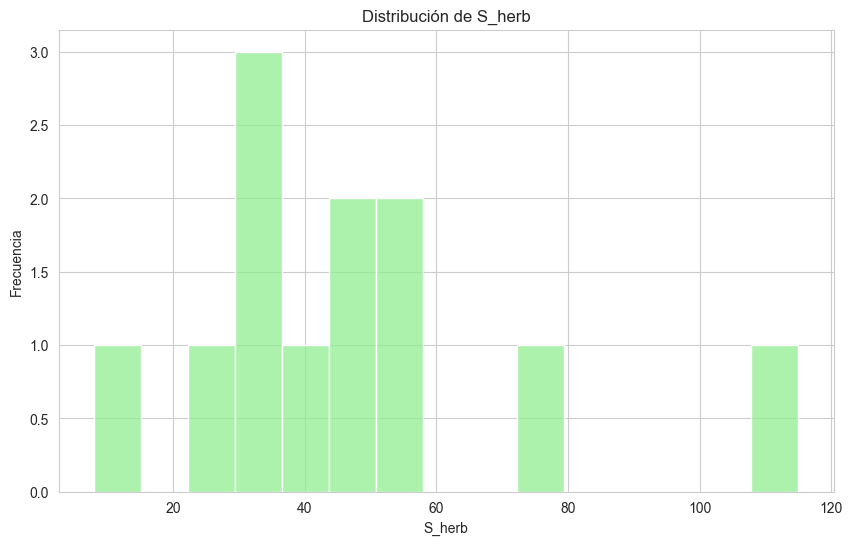

Estadísticas para S_herb:
Media: 47.3333
Varianza: 760.2424
Ratio Varianza/Media: 16.0615

INTERPRETACIÓN: La varianza es mayor que la media (Ratio > 1.5).
Esto sugiere SOBREDISPERSIÓN. Probablemente la Binomial Negativa sea mejor.


In [3]:
variable_respuesta = 'S_herb'

# 1. Histograma
plt.figure(figsize=(10, 6))
sns.histplot(df[variable_respuesta], kde=False, bins=15, color='lightgreen')
plt.title(f'Distribución de {variable_respuesta}')
plt.xlabel(variable_respuesta)
plt.ylabel('Frecuencia')
plt.show()

# 2. Cálculo de Media y Varianza
media = df[variable_respuesta].mean()
varianza = df[variable_respuesta].var()
ratio = varianza / media

print(f"Estadísticas para {variable_respuesta}:")
print(f"Media: {media:.4f}")
print(f"Varianza: {varianza:.4f}")
print(f"Ratio Varianza/Media: {ratio:.4f}")

if ratio > 1.5:
    print("\nINTERPRETACIÓN: La varianza es mayor que la media (Ratio > 1.5).")
    print("Esto sugiere SOBREDISPERSIÓN. Probablemente la Binomial Negativa sea mejor.")
elif ratio < 0.9:
    print("\nINTERPRETACIÓN: La varianza es menor que la media (Subdispersión).")
else:
    print("\nINTERPRETACIÓN: La varianza es similar a la media.")
    print("El modelo de Poisson podría ser adecuado.")

## 3. Ajuste de Modelos (GLM)

Ajustaremos ambos modelos usando `Prc_expuesto` (Apertura) como variable predictora.

In [4]:
# Definir la fórmula
formula = f"{variable_respuesta} ~ Prc_expuesto"

# --- Modelo Binomial Negativo ---
# Usamos smf.negativebinomial que estima alpha automáticamente
modelo_nb = smf.negativebinomial(formula=formula, data=df).fit()

print("--- Resumen Modelo Binomial Negativo ---")
print(modelo_nb.summary())

# Extraer resultados para la tabla
coeficientes = modelo_nb.params
errores = modelo_nb.bse
z_values = modelo_nb.tvalues
p_values = modelo_nb.pvalues
aic = modelo_nb.aic

# Crear tabla resumen
tabla_resumen = pd.DataFrame({
    'Variable respuesta': [variable_respuesta] * len(coeficientes),
    'Modelo (familia)': ['Binomial Negativa'] * len(coeficientes),
    'Variables explicativas': coeficientes.index,
    'Coeficiente': coeficientes.values,
    'Error estándar': errores.values,
    'z': z_values.values,
    'p': p_values.values,
    'AIC': [aic] * len(coeficientes) # El AIC es del modelo, se repite
})

# Formatear tabla
# Mapear nombres de variables si es necesario para que se vea mejor
nombres_vars = {'Intercept': 'Intercepto', 'Prc_expuesto': 'Apertura (Prc_expuesto)', 'alpha': 'Alpha'}
tabla_resumen['Variables explicativas'] = tabla_resumen['Variables explicativas'].map(nombres_vars).fillna(tabla_resumen['Variables explicativas'])

# Reordenar columnas
cols = ['Variable respuesta', 'Modelo (familia)', 'Variables explicativas', 'Coeficiente', 'Error estándar', 'z', 'p', 'AIC']
tabla_resumen = tabla_resumen[cols]

print("\nTabla de Resultados Importantes:")
print(tabla_resumen)

# Opcional: Mostrar bonito en notebook
display(tabla_resumen)

Optimization terminated successfully.
         Current function value: 4.556827
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
--- Resumen Modelo Binomial Negativo ---
                     NegativeBinomial Regression Results                      
Dep. Variable:                 S_herb   No. Observations:                   12
Model:               NegativeBinomial   Df Residuals:                       10
Method:                           MLE   Df Model:                            1
Date:                Thu, 04 Dec 2025   Pseudo R-squ.:                0.006893
Time:                        08:04:08   Log-Likelihood:                -54.682
converged:                       True   LL-Null:                       -55.061
Covariance Type:            nonrobust   LLR p-value:                    0.3836
                   coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------

,Variable respuesta,Modelo (familia),Variables explicativas,Coeficiente,Error estándar,z,p,AIC
0,S_herb,Binomial Negativa,Intercepto,3.342466,0.575768,5.805231,6.427744e-09,115.363837
1,S_herb,Binomial Negativa,Apertura (Prc_expuesto),0.698182,0.763390,0.914581,3.604116e-01,115.363837
2,S_herb,Binomial Negativa,Alpha,0.270996,0.117194,2.312373,2.075714e-02,115.363837
